In [1]:
#import modules
%pylab inline

from astropy.cosmology import Planck13
from astropy.io import fits
from simqso.sqgrids import *
from simqso import sqbase
from simqso.sqrun import buildSpectraBulk,buildQsoSpectrum,save_spectra,load_spectra,restore_qso_grid
from simqso.sqmodels import BOSS_DR9_PLEpivot,get_BossDr9_model_vars
random.seed(12345)

Populating the interactive namespace from numpy and matplotlib


In [2]:
#wave = sqbase.fixed_R_dispersion(1000,20e4,1000)  #UV/IR mid resolution
wave = sqbase.fixed_R_dispersion(3000,5e4,500)    #optical/IR low resolution

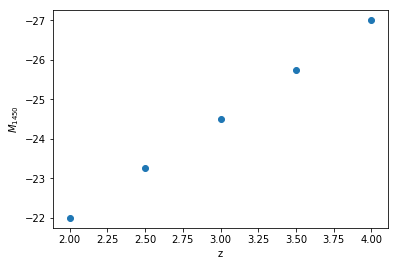

In [3]:
nqso = 5
M = AbsMagVar(FixedSampler(linspace(-27,-22,nqso)[::-1]),restWave=1450)
z = RedshiftVar(FixedSampler(linspace(2,4,nqso)))
qsos = QsoSimPoints([M,z],cosmo=Planck13,units='luminosity')
scatter(qsos.z,qsos.absMag)
xlabel('z')
ylabel('$M_{1450}$')
ylim(-21.75,-27.25);

In [4]:
contVar = BrokenPowerLawContinuumVar([GaussianSampler(-1.5,0.3),
                                      GaussianSampler(-0.5,0.3)],
                                     [1215.])

In [5]:
subDustVar = DustBlackbodyVar([ConstSampler(0.05),ConstSampler(1800.)],
                               name='sublimdust')
subDustVar.set_associated_var(contVar)
hotDustVar = DustBlackbodyVar([ConstSampler(0.1),ConstSampler(880.)],
                               name='hotdust')
hotDustVar.set_associated_var(contVar)

In [6]:
emLineVar = generateBEffEmissionLines(qsos.absMag)

In [7]:
fescales = [(0,1540,0.5),(1540,1680,2.0),(1680,1868,1.6),(1868,2140,1.0),(2140,3500,1.0)]
feVar = FeTemplateVar(VW01FeTemplateGrid(qsos.z,wave,scales=fescales))

In [8]:
# Now add the features to the QSO grid
qsos.addVars([contVar,subDustVar,hotDustVar,emLineVar,feVar])

In [9]:
# ready to generate spectra
_,spectra = buildSpectraBulk(wave,qsos,saveSpectra=True)
#qsos.loadPhotoMap([('DECam','DECaLS'),('WISE','AllWISE')])
#_,spectra = buildSpectraBulk(wave,qsos,saveSpectra=True,maxIter=3,verbose=20)

In [10]:
qsos.data

z,absMag,slopes [2],sublimdust [2],hotdust [2],"emLines [62,3]"
float32,float32,float32,float32,float32,float32
2.0,-22.0,-1.3791935 .. -0.39047506,0.05 .. 1800.0,0.1 .. 880.0,1034.7156 .. 324.49664
2.5,-23.25,-1.2368382 .. -0.32741192,0.05 .. 1800.0,0.1 .. 880.0,1033.7252 .. 368.25366
3.0,-24.5,-1.1589788 .. -0.524392,0.05 .. 1800.0,0.1 .. 880.0,1033.4135 .. 228.17398
3.5,-25.75,-0.95778936 .. -0.6356415,0.05 .. 1800.0,0.1 .. 880.0,1033.3096 .. 260.35233
4.0,-27.0,-1.3218526 .. -0.5455611,0.05 .. 1800.0,0.1 .. 880.0,1033.59 .. 282.773


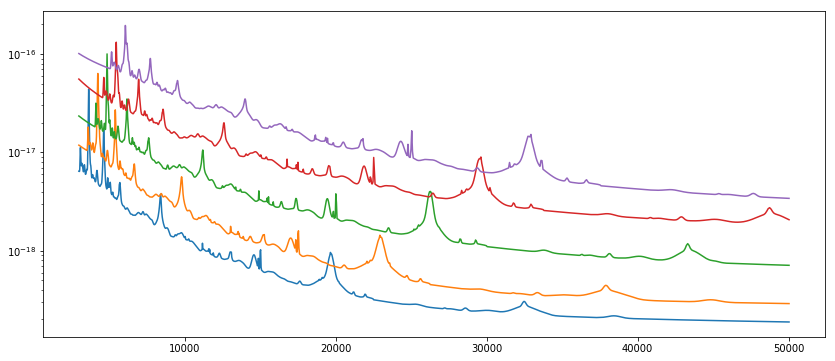

In [11]:
figure(figsize=(14,6))
for sp in spectra:
    plot(wave,sp)
yscale('log')

(3000, 10000)

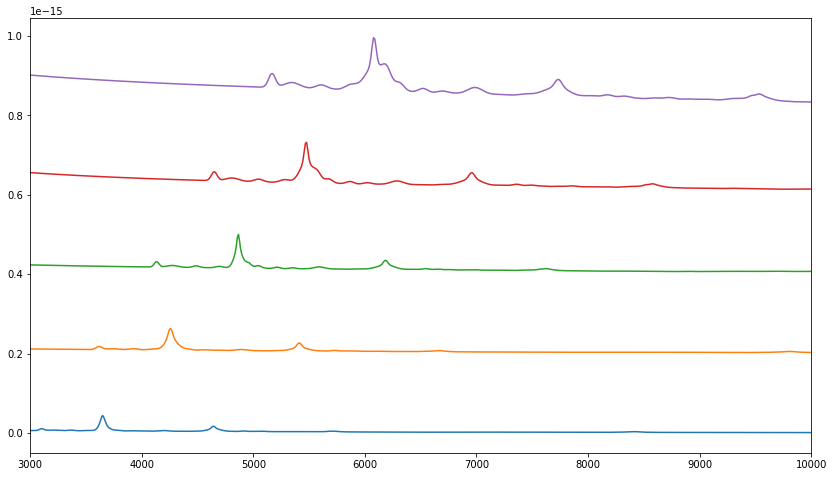

In [29]:
figure(figsize=(14,8))
for i,sp in enumerate(spectra):
    plot(wave,sp+i*2e-16)
xlim(3000,10000)
#xlim(3000,7000)

Divide the spectrum into components. Offset the emission line and iron template features for clarity.

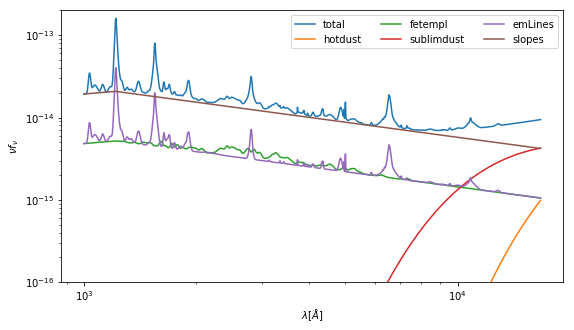

In [13]:
sp,comp = buildQsoSpectrum(wave,qsos.cosmo,qsos.getVars(SpectralFeatureVar),
                           qsos.data[0],save_components=True)
z1 = sp.z + 1
figure(figsize=(9,5))
plot(sp.wave/z1,sp.wave*sp.f_lambda,label='total')
for cname,cspec in comp.items():
    flam = cspec.f_lambda
    if cname in ['emLines','fetempl']:
        flam = 0.25*comp['slopes'].f_lambda*(1+flam)
    plot(cspec.wave/z1,cspec.wave*flam,label=cname)
legend(ncol=3)
ylim(1e-16,2e-13)
#ylim(1e-13,2e-11)
xscale('log')
yscale('log')
xlabel('$\lambda [\AA]$')
ylabel(r'$\nu{f}_\nu$');

In [14]:
qsos.write('quasar2_meta',extname='quasar2',overwrite=True)

In [15]:
ff = fits.open('quasar2_meta.fits')
ff.info()

Filename: quasar2_meta.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  QUASAR2       1 BinTableHDU     53   5R x 6C   [E, E, 2E, 2E, 2E, 186E]   


In [16]:
save_spectra(wave,spectra,'quasar2')

In [17]:
wave,spec = load_spectra('quasar2')

In [18]:
qsos_restore = restore_qso_grid('quasar2_meta',wave,extname='quasar2')

In [19]:
specs0 = buildQsoSpectrum(wave,qsos_restore.cosmo,
                         qsos_restore.getVars(SpectralFeatureVar),
                         qsos_restore.data[0])

z,absMag,slopes [2],sublimdust [2],hotdust [2],"emLines [62,3]"
float32,float32,float32,float32,float32,float32
2.0,-22.0,-1.3791935 .. -0.39047506,0.05 .. 1800.0,0.1 .. 880.0,1034.7156 .. 324.49664


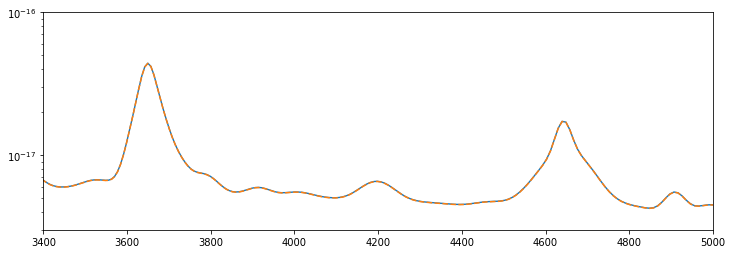

In [20]:
figure(figsize=(12,4))
plot(wave,spectra[0],lw=1.4)
plot(wave,specs0.f_lambda,ls='--')
yscale('log')
ylim(3e-18,10e-17)
xlim(3400,5000);#1e4);
qsos.data[0]

In [21]:
spec1 = buildQsoSpectrum(wave,qsos_restore.cosmo,
                         qsos_restore.getVars(SpectralFeatureVar),
                         qsos_restore.data[1])

z,absMag,slopes [2],sublimdust [2],hotdust [2],"emLines [62,3]"
float32,float32,float32,float32,float32,float32
2.5,-23.25,-1.2368382 .. -0.32741192,0.05 .. 1800.0,0.1 .. 880.0,1033.7252 .. 368.25366


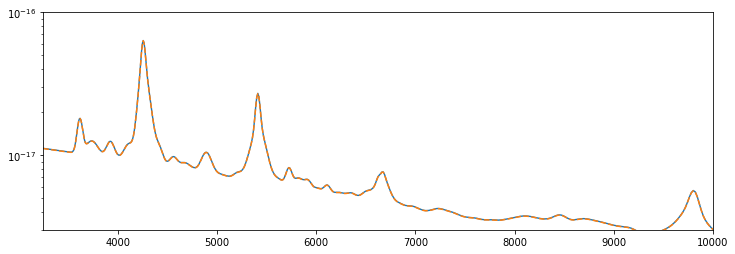

In [22]:
figure(figsize=(12,4))
plot(wave,spectra[1],lw=1.4)
plot(wave,spec1.f_lambda,ls='--')
yscale('log')
ylim(3e-18,10e-17)
xlim(3250,1e4);
qsos.data[1]

In [23]:
_,allspec = buildSpectraBulk(wave,qsos_restore)

Text(0, 0.5, '$\\lambda{f}_\\lambda}$')

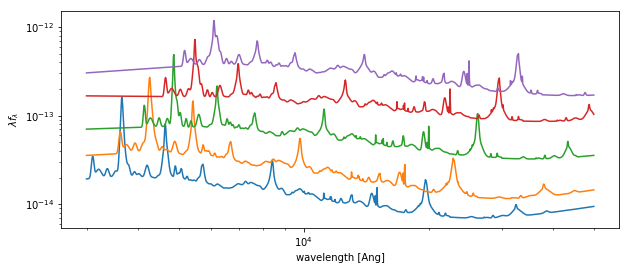

In [24]:
figure(figsize=(10,4))
plot(wave,(wave*spectra).transpose())
xscale('log')
yscale('log')
xlabel('wavelength [Ang]')
ylabel(r'$\lambda{f}_\lambda}$')
#ylim(1e-14,1e-12);

In [25]:
spec2 = buildQsoSpectrum(wave,qsos_restore.cosmo,
                         qsos_restore.getVars(SpectralFeatureVar),
                         qsos_restore.data[2])

z,absMag,slopes [2],sublimdust [2],hotdust [2],"emLines [62,3]"
float32,float32,float32,float32,float32,float32
3.0,-24.5,-1.1589788 .. -0.524392,0.05 .. 1800.0,0.1 .. 880.0,1033.4135 .. 228.17398


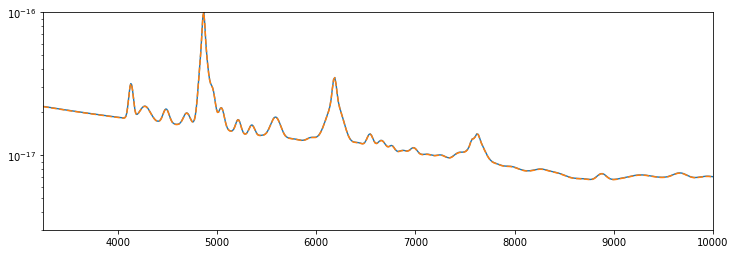

In [26]:
figure(figsize=(12,4))
plot(wave,spectra[2],lw=1.4)
plot(wave,spec2.f_lambda,ls='--')
yscale('log')
ylim(3e-18,10e-17)
xlim(3250,1e4);
qsos.data[2]